In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES']='0'
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [2]:
from coin_if import COINWrapper,read_COIN_params

In [3]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

from types import SimpleNamespace

In [4]:
from multiprocessing import Pool

# Create a helper function that unpacks a tuple of arguments
def parallel_wrapped_runner_item(args):
    k, stimuli_data, opt_data_k = args
    return k, wrapped_runner(stimuli_data, opt_data_k)

def parallel_wrapped_runner(args_list, return_dict=False):
    with Pool() as pool:
        results = pool.map(parallel_wrapped_runner_item,args_list)
    if return_dict:
        return dict(results)
    else: # list of result items
        return [results[1]  for results in results]



In [5]:
from coin_if import read_COIN_params
raw_coin_params = read_COIN_params('/fitted_parameters/')

In [6]:
args = SimpleNamespace()
args.paradigm = ['evoked_recovery', 'spontaneous_recovery','memory_updating']

paradigm_short = {
    'evoked_recovery': 'E',
    'spontaneous_recovery': 'S',
    'memory_updating': 'M',
}

paradigm_info = {
    'evoked_recovery': {
        'i_min': 1,
        'i_max': 8,},

    'spontaneous_recovery': {
        'i_min': 1,
        'i_max': 8,},
    'memory_updating': {
        'i_min': 1,
        'i_max': 24,},
    
    }



In [7]:
data = {}
opt_data = {}
paradigm_by_id_lut = {}
id = 0
param_names = [k for k in raw_coin_params['E1'].keys()]

# 
param_remapping = {'prior_sigma_retention': {'name':'prior_precision_retention', 'fun': lambda x: 1/x**2},
                   'prior_sigma_drift': {'name':'prior_precision_drift', 'fun': lambda x: 1/x**2}}

def remap_params(params):
    for k in param_remapping.keys():
        if k in params:
            new_name = param_remapping[k]['name']
            new_value = param_remapping[k]['fun'](params[k])
            params[new_name] = new_value
            del params[k]
    return params
                   

if type(args.paradigm) is not str:
    for paradigm in args.paradigm:
        for i in range(paradigm_info[paradigm]['i_min'],paradigm_info[paradigm]['i_max']+1):
            # with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
            # with open(f'{ROOT_PATH}/experimental/coin_{args.paradigm}_run011s_MSE_{i}.pkl','rb') as f:
            
            # with open(f'{ROOT_PATH}/experimental/coin_{paradigm}_run012_MSE_{i}.pkl','rb') as f:
            #     opt_data[id] = pickle.load(f)
            kk = paradigm_short[paradigm]+str(i)
            #opt_data[id] = {'MSE':{'x':[raw_coin_params[kk][p] for p in param_names]}}
            opt_data[id] = {'MSE':{'x':[]}}
            for p in param_names:
                _val = raw_coin_params[kk][p]
                if p in param_remapping.keys():
                    _val = param_remapping[p]['fun'](_val)
                opt_data[id]['MSE']['x'].append(_val)
            
            paradigm_by_id_lut[id] = paradigm

            df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/COIN_data/trial_data_{paradigm}_participant{i}.csv')
            y = df.Adaptation.to_numpy()
            y *= np.sign(np.nansum(y))
            data[id] = y

            id += 1

#remapping param_names
new_param_names = []
for k in param_names:
    if k in param_remapping.keys():
        new_param_names.append(param_remapping[k]['name'])
    else:
        new_param_names.append(k)
param_names = new_param_names

In [ ]:
def scale_and_bias(x,bias=0,scale=1.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}


fixed_params['model'] =  dict(runs=1)  #set_COIN_runs_here      

fixed_params['runner'] = {
    "runner_method_alias": "blackbox",  
    "model_type": "coin",               # Distinguish from 'torch' or 'numpy'
    "do_backprop": False,               # No training/backpropagation for COIN
    "load_model_at_init": False,        # COIN doesn’t support state_dict saving/loading
    "save_model_at_init": False,        # Ensure no torch parameter saving is attempted
    'initial_state': [], 
    "tau_u": 1,                        # Can be set if needed (may be unused in COIN mode)
}



optim_param_mapping= [('model', param_name) for param_name in param_names] 
            
custom_param_mappings = []

wrapped_runner = wrap_runner_for_optimization(model_class = COINWrapper,
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [9]:
Pplus = 1
Pminus = -1
P0 = 0
Pchannel = np.nan

'''
spontaneous:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp150: 150


evoked:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp2: 2
trials in block FieldA2: 2
trials in block Clamp150: 146
'''
stimuli = {'spontaneous_recovery': [(P0, 50),
                        (Pplus, 120),
                        (Pminus, 15),
                        (Pchannel, 150)],
            'evoked_recovery': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 2),
                        (Pplus, 2),
                        (Pchannel, 146)],
                        'memory_updating': [(P0, 50)]}


datapoint_mapping=None

In [10]:
pooling_fun = 'MSE'

In [11]:
outs = parallel_wrapped_runner([(k,stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data],return_dict=True)

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weigh

Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coi

Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Simulting the COIN model

100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s].75s/it]

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]
/homes/ar2342/frogs_project/COIN_Python/coin.py:607: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:607: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:607: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:607: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:607: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:607: RuntimeWarning: divide by zero encountered

In [12]:
# outs  = {k: wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data}

Text(0.5, 1.0, 'subjects -->>1')

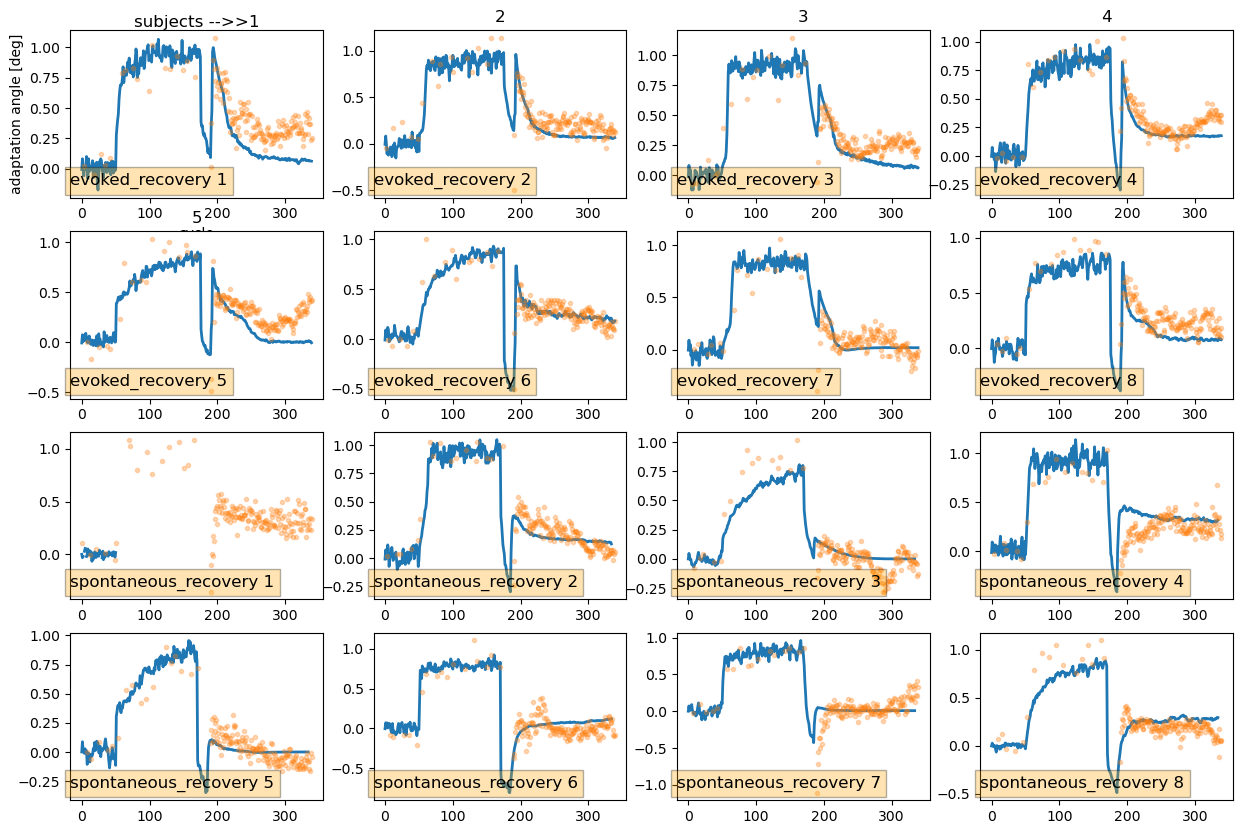

In [13]:
plt.figure(figsize=(15,10))
for k in opt_data:
    if k > 15:
        continue
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))



plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [14]:
A_times = [0,5,10,20,30,100] 
antero_short = {aa: parallel_wrapped_runner([(k,[(0,20),(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data]) for aa,A_time in enumerate(A_times)}
antero_short_preambled = {aa: parallel_wrapped_runner([(k,[(0,150),(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data]) for aa,A_time in enumerate(A_times)}

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN modelSimulting the COIN model




/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"]

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
100%|██████████| 1/1 [00:02<00:00,  2.12s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)


Simulting the COIN model


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:01<00:00,  2.00s/it]

Simulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]


Simulting the COIN modelSimulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]



Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]


Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: 

Simulting the COIN model


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]

Simulting the COIN model


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


Simulting the COIN model

100%|██████████| 1/1 [00:02<00:00,  2.81s/it]

100%|██████████| 1/1 [00:02<00:00,  2.81s/it]

100%|██████████| 1/1 [00:02<00:00,  3.00s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:02<00:00,  2.96s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN modelSimulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]


Simulting the COIN modelSimulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]



Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model
Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: Runt

Simulting the COIN model


100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:03<00:00,  3.29s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

Simulting the COIN model

100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

100%|██████████| 1/1 [00:02<00:00,  2.30s/it]

Simulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


100%|██████████| 1/1 [00:03<00:00,  3.33s/it]


Simulting the COIN model

100%|██████████| 1/1 [00:02<00:00,  2.97s/it]

100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

Simulting the COIN model

100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


100%|██████████| 1/1 [00:02<00:00,  2.98s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

100%|██████████| 1/1 [00:03<00:00,  3.01s/it]

100%|██████████| 1/1 [00:03<00:00,  3.01s/it]

100%|██████████| 1/1 [00:03<00:00,  3.42s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general

Simulting the COIN model
Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountere

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:03<00:00,  3.34s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:03<00:00,  3.62s/it]



Simulting the COIN modelSimulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.52s/it]

100%|██████████| 1/1 [00:03<00:00,  3.43s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:03<00:00,  3.68s/it]

100%|██████████| 1/1 [00:03<00:00,  3.91s/it]/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:02<00:00,  2.26s/it]



Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountere

Simulting the COIN model
Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]


Simulting the COIN modelSimulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: di

Simulting the COIN model

Simulting the COIN model



100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:03<00:00,  3.83s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)


Simulting the COIN model


100%|██████████| 1/1 [00:03<00:00,  3.99s/it]


Simulting the COIN model

100%|██████████| 1/1 [00:03<00:00,  3.99s/it]

  0%|          | 0/1 [00:00<?, ?it/s].99s/it]


Simulting the COIN model

100%|██████████| 1/1 [00:03<00:00,  3.38s/it]

100%|██████████| 1/1 [00:03<00:00,  3.62s/it]

100%|██████████| 1/1 [00:03<00:00,  3.98s/it]

100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/fr

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN modelSimulting the COIN model


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/fr

Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
100%|██████████| 1/1 [00:04<00:00,  4.99s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.12s/it]

Simulting the COIN model


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.64s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.77s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.13s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.39s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:07<00:00,  7.65s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:05<00:00,  5.16s/it]


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c

Simulting the COIN model
Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.28s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.94s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.92s/it]


Simulting the COIN model

100%|██████████| 1/1 [00:06<00:00,  6.51s/it]

100%|██████████| 1/1 [00:06<00:00,  6.51s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.40s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.29s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:06<00:00,  6.88s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:05<00:00,  5.69s/it]


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountere

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: di

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN modelSimulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: di

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
100%|██████████| 1/1 [00:06<00:00,  6.59s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.17s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.72s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.74s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.83s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.92s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.03s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.23s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:08<00:00,  8.26s/it]

100%|██████████| 1/1 [00:05<00:00,  5.34s/it]


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coi

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN modelSimulting the COIN model




  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN modelSimulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: Runt

Simulting the COIN model
Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general

Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.68s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.77s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.39s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.15s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.08s/it]/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)



Simulting the COIN modelSimulting the COIN model



100%|██████████| 1/1 [00:08<00:00,  8.67s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:06<00:00,  6.23s/it]


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN modelSimulting the COIN modelSimulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: 

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN modelSimulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)




Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/fr

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
100%|██████████| 1/1 [00:07<00:00,  7.46s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  7.00s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.96s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.34s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.99s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.02s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.19s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.17s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:06<00:00,  6.46s/it]


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model

Simulting the COIN modelSimulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN modelSimulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/fr

Simulting the COIN modelSimulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: 

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
100%|██████████| 1/1 [00:07<00:00,  7.46s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.48s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.36s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.88s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.50s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.40s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.10s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.58s/it]



Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.61s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:06<00:00,  6.58s/it]


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/fr

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model

Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/fr

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
100%|██████████| 1/1 [00:10<00:00, 10.90s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:11<00:00, 11.56s/it]

/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

Simulting the COIN model


100%|██████████| 1/1 [00:10<00:00, 10.97s/it]


Simulting the COIN model

100%|██████████| 1/1 [00:11<00:00, 11.72s/it]

100%|██████████| 1/1 [00:11<00:00, 11.72s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:11<00:00, 11.18s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:11<00:00, 11.77s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.85s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:14<00:00, 14.10s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:73: RuntimeWarning: Mean of empty slice
  motor_output = np.nanmean([run["motor_output"] for _,run in runs.items()], axis=0)
100%|██████████| 1/1 [00:07<00:00,  7.80s/it]


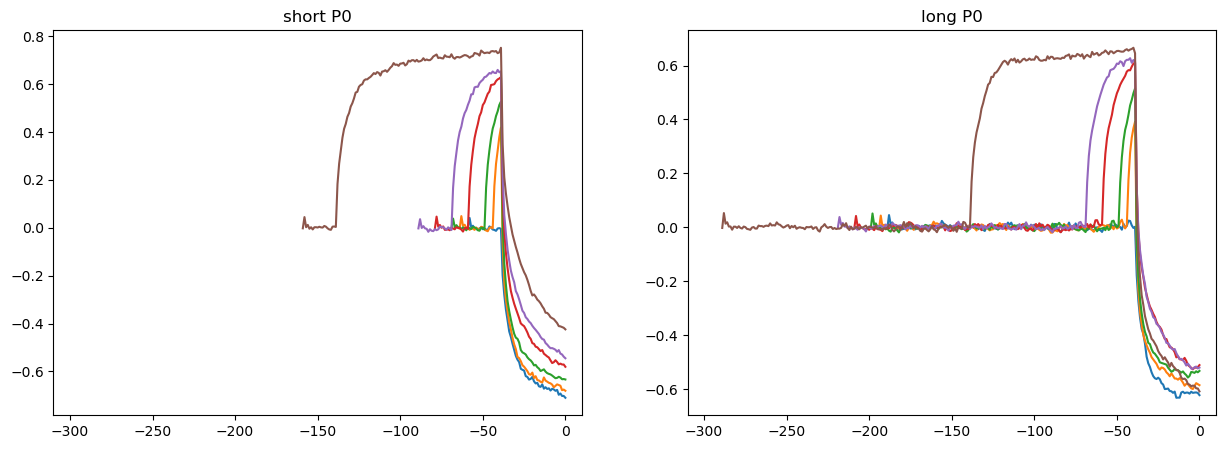

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for aa,A_time in enumerate(A_times):
    y = np.nanmean(antero_short[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
    # plt.title(f'average over {len(antero_short[aa])} subjects')
    plt.title(f'short P0')
    plt.xlim([-310,10])

plt.subplot(1,2,2)

for aa,A_time in enumerate(A_times):
    y = np.nanmean(antero_short_preambled[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
    plt.title(f'long P0')
    plt.xlim([-310,10])


In [ ]:
TaN=150
TaB=120

ref_antero_playlist = {'AB0':[(P0, TaN),(Pminus, TaB)],
'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
'AB4':[(P0, TaN),(Pplus,230),(Pminus, TaB)],
'AB5':[(P0, TaN),(Pplus,410),(Pminus, TaB)]}

# antero   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in ref_antero_playlist.items()}
antero = {aa: parallel_wrapped_runner([(k,aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data]) for aa,aa_item in ref_antero_playlist.items()}
for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
for aa,A_time in enumerate(A_times):
    y = np.mean(antero_short[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)


NameError: name 'stop_here' is not defined

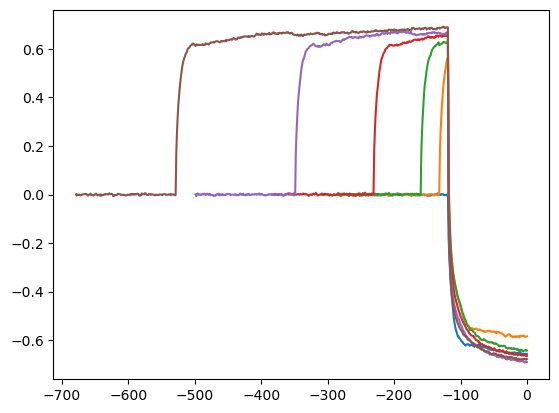

In [ ]:
for aa,aa_item in antero.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

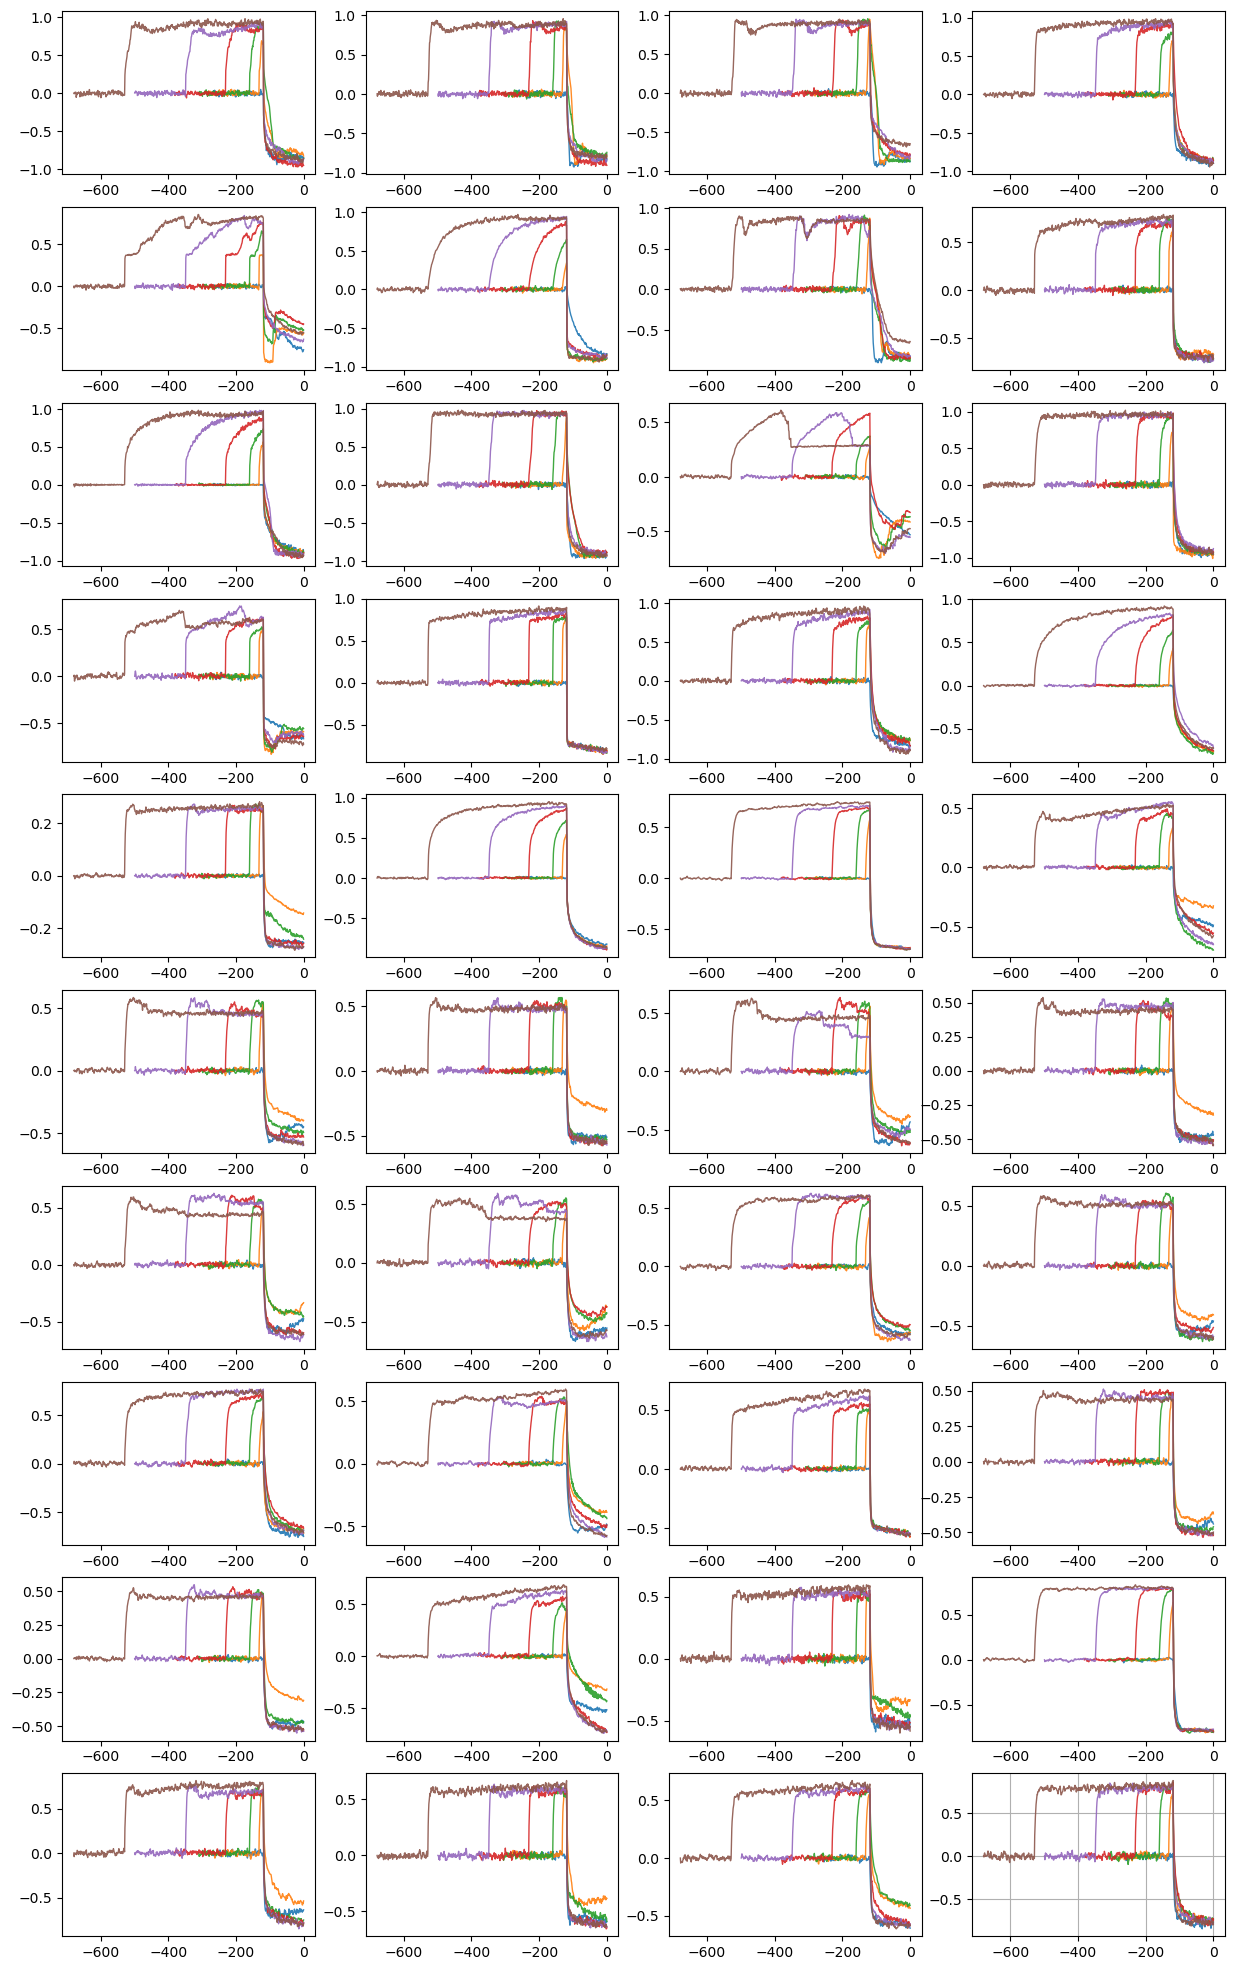

In [ ]:
plt.figure(figsize=(15,25))
for ii in range(40):
    for aa,aa_item in antero.items():
        plt.subplot(10,4,ii+1)
        y = antero[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
plt.grid()

In [ ]:
frog_ens = [True,False]
Tfrog = 400
frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.69s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.01s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.73s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.56s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.55s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.74s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:10<00:00, 10.58s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.23s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.96s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.53s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.14s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.03s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.61s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.42s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.23s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.86s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.44s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.45s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.57s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.79s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.40s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.43s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.42s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.49s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.40s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.44s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.46s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.51s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.17s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.46s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.32s/it]


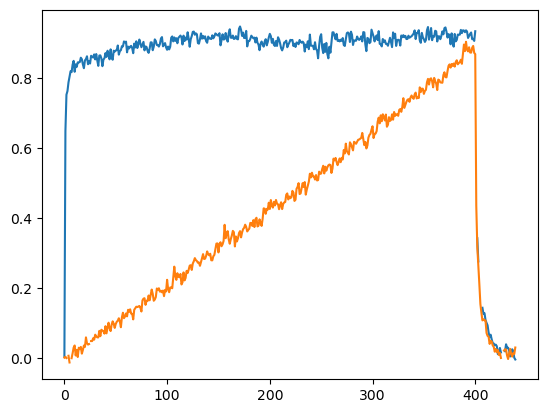

In [ ]:
for frog_en in frog_ens:
    plt.plot(np.mean(frogs[frog_en],axis=0))

In [ ]:
from siggen_utils import herzfeld_block


def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
hrz_playlist =  generate_herzfeld_scenarios(**hrz_params)
her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:47<00:00, 47.82s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:37<00:00, 37.83s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:37<00:00, 37.27s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:36<00:00, 36.95s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:54<00:00, 54.45s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:52<00:00, 52.23s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:44<00:00, 44.29s/it]


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

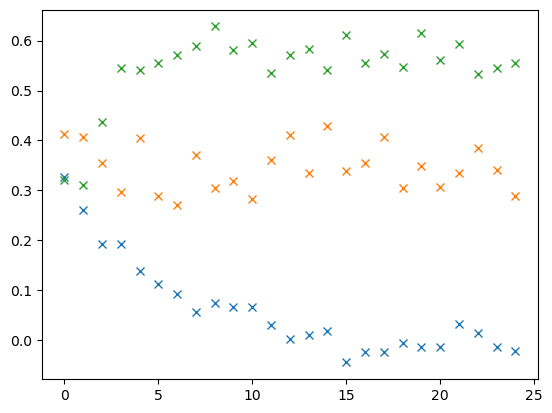

In [ ]:
for iz, z in enumerate(hrz_params['z_list']):
    deltas = []
    mm = lambda x: np.mean(x,axis=0)
    scenario = f'herzfeld,z={z}'
    this_result = her_results[scenario]
    pointer = 0
    for bb in range(hrz_params['n_blocks']):
        block_length = hrz_playlist[scenario][bb][-1]
        pointer += block_length
        deltas.append(mm(her_results[scenario])[pointer-1]-mm(her_results[scenario])[pointer-3])            

    plt.plot(deltas,'x',label = f'z={z}')

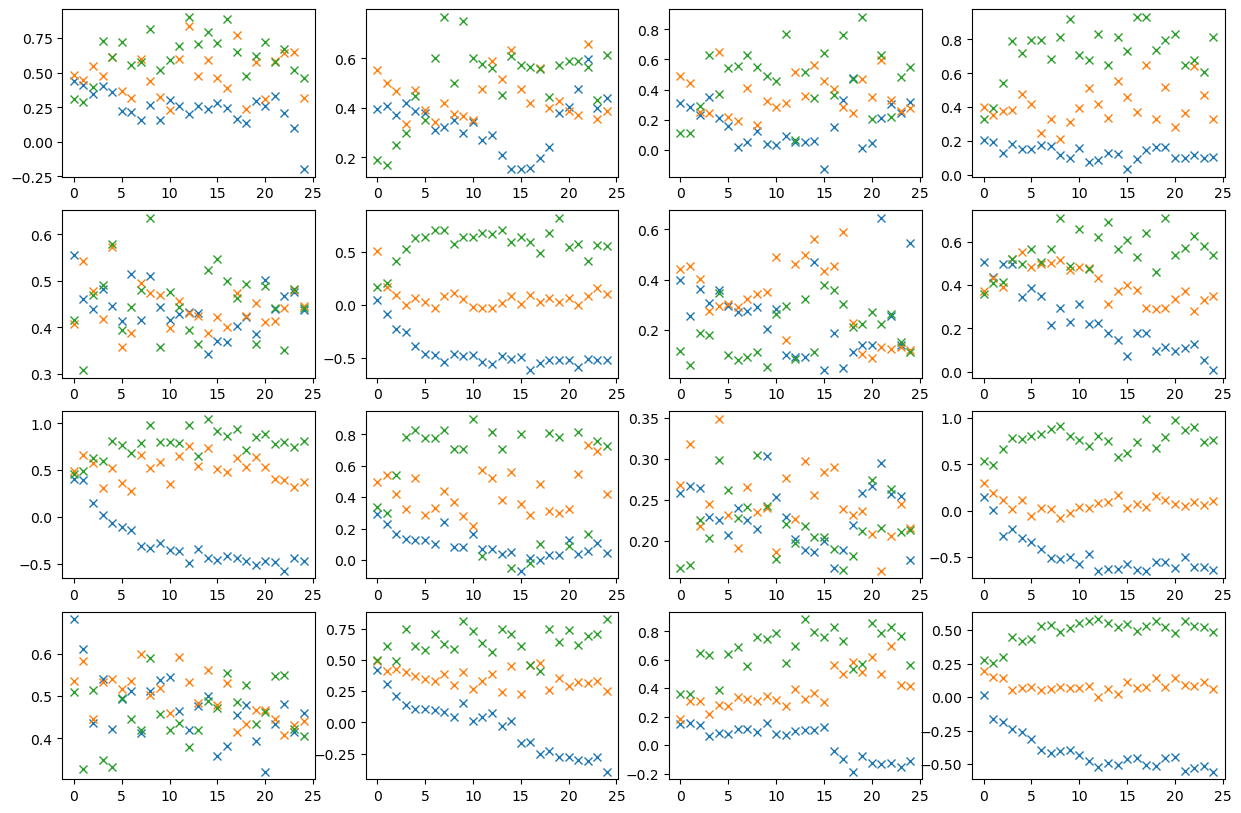

In [ ]:
plt.figure(figsize=(15,10))
for iz, z in enumerate(hrz_params['z_list']):
    for ii in range(16):
        plt.subplot(4,4,ii+1)
        deltas = []
        mm = lambda x: np.mean(x,axis=0)
        scenario = f'herzfeld,z={z}'
        this_result = her_results[scenario]
        pointer = 0
        for bb in range(hrz_params['n_blocks']):
            block_length = hrz_playlist[scenario][bb][-1]
            pointer += block_length
            deltas.append((her_results[scenario])[ii][pointer-1]-(her_results[scenario])[ii][pointer-3])            

        plt.plot(deltas,'x',label = f'z={z}')

In [ ]:
plt.figure(figsize=(15,10))
for iz, z in enumerate(hrz_params['z_list']):
    for ii in range(16):
        plt.subplot(4,4,ii+1)
        deltas = []
        mm = lambda x: np.mean(x,axis=0)
        scenario = f'herzfeld,z={z}'
        this_result = her_results[scenario]
        pointer = 0
        for bb in range(hrz_params['n_blocks']):
            block_length = hrz_playlist[scenario][bb][-1]
            pointer += block_length
            deltas.append((her_results[scenario])[ii][pointer-1]-(her_results[scenario])[ii][pointer-3])            

        plt.plot(deltas,'x',label = f'z={z}')

NameError: name 'plt' is not defined

In [ ]:
np.shape(her_results[scenario][0][pointer-1])

()

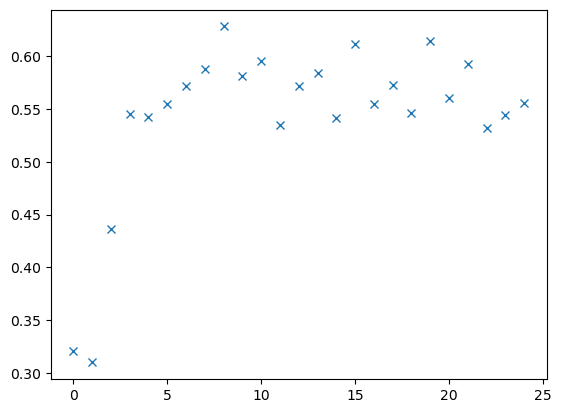

In [ ]:
plt.plot(deltas,'x',label = f'z={z}')

In [ ]:
playlist = {'Ac':[(P0, 200),(Pplus, 200),(Pchannel,200)],
            'ABc':[(P0, 200),(Pplus, 200),(Pminus, 200),(Pchannel,200)]}

results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in playlist.items()}


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:17<00:00, 17.02s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:15<00:00, 15.93s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:17<00:00, 17.50s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.84s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.77s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:15<00:00, 15.23s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.53s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.68s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:14<00:00, 14.97s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.59s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.47s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.57s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.86s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.28s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:13<00:00, 13.13s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:17<00:00, 17.14s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:29<00:00, 29.80s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:24<00:00, 24.60s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.89s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:22<00:00, 22.73s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:27<00:00, 27.00s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:36<00:00, 36.24s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.76s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.87s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:26<00:00, 26.69s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:21<00:00, 21.54s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:26<00:00, 26.38s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:23<00:00, 23.34s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:19<00:00, 19.79s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:23<00:00, 23.72s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.17s/it]


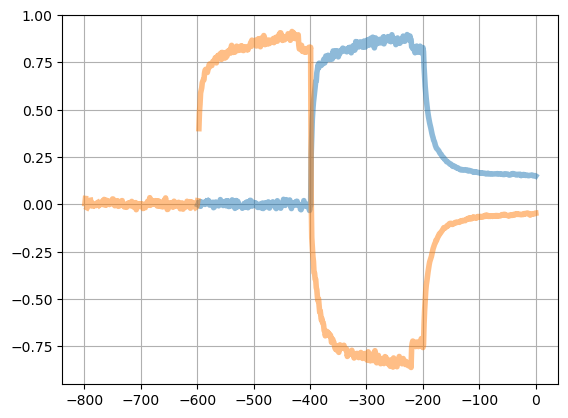

In [ ]:
for aa,aa_item in results.items():
    y = np.mean(results[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y, linewidth=4, alpha=0.5)
plt.grid()

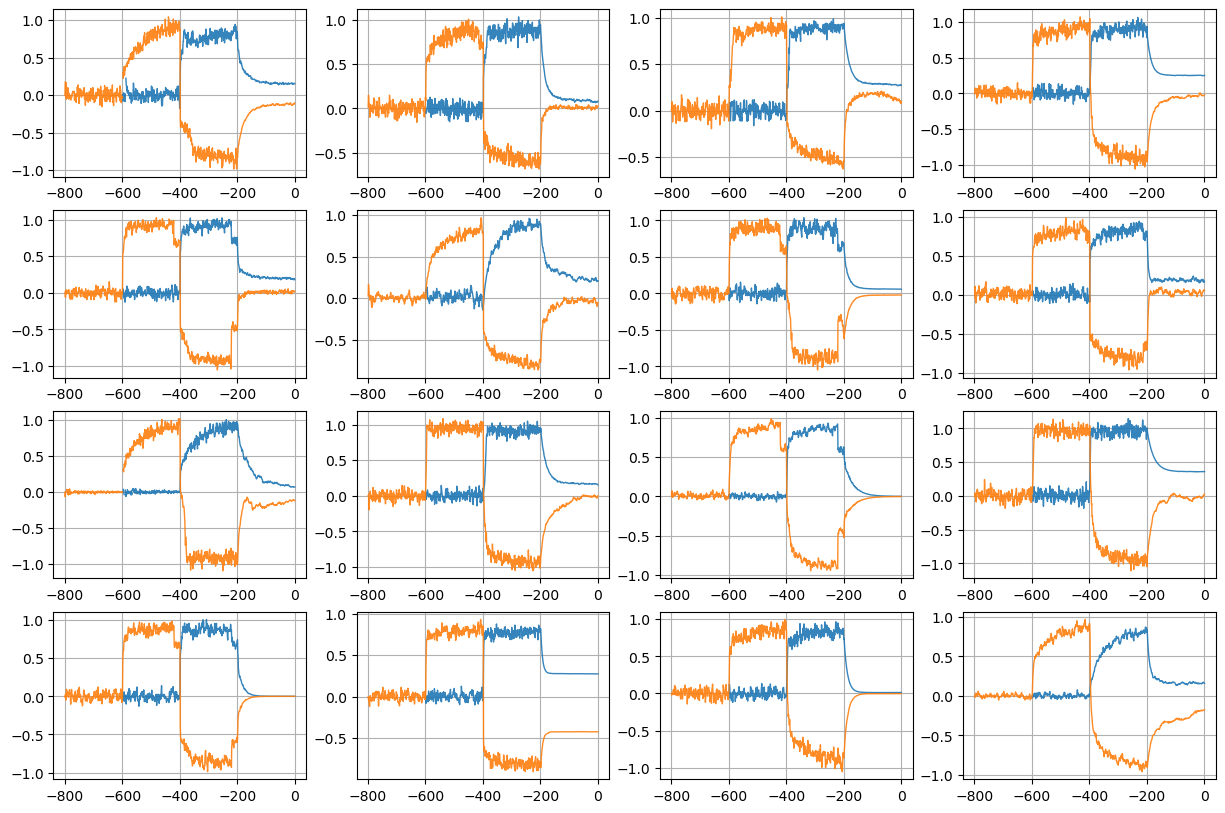

In [ ]:
plt.figure(figsize=(15,10))
for ii in range(16):
    for aa,aa_item in results.items():
        plt.subplot(4,4,ii+1)
        y = results[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
    plt.grid()

In [ ]:
for ii in range(16):
    for aa,aa_item in results.items():
        plt.subplot(4,4,ii+1)
        y = results[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
plt.grid()

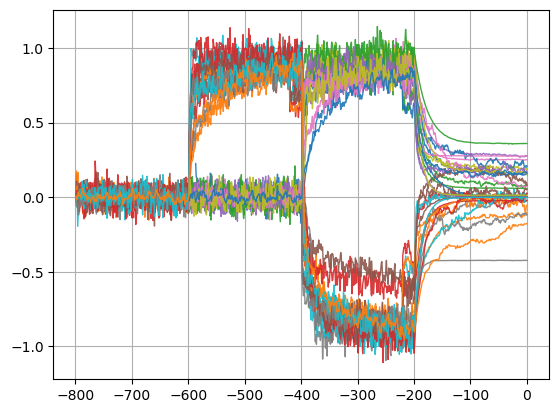

In [ ]:
for ii in range(16):
    for aa,aa_item in results.items():
        # plt.subplot(4,4,ii+1)
        y = results[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
plt.grid()